# Student Performance Analytics & Prediction

## Problem Statement
Educational institutions often struggle to identify students who are at risk of poor academic performance early. This project analyzes student academic and behavioral data to understand key factors influencing performance and builds predictive models to estimate final grades.

## Hypothesis
Previous academic performance, study habits, and attendance significantly influence a student's final grade.

## Objectives
- Perform exploratory data analysis (EDA)
- Engineer meaningful features
- Train and compare regression models
- Evaluate models using multiple metrics
- Extend analysis to classify at-risk students
- Provide actionable academic insights


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score
)

## Dataset Overview
The dataset contains demographic, academic, and behavioral attributes of students.
The target variable for regression is **G3**, representing the final grade.

In [9]:
df = pd.read_csv("student-mat.csv", sep=',')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [7]:
df = pd.read_csv("student-mat.csv", sep=',')
df.columns


Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

## Feature Engineering
An average of previous grades (G1 and G2) is created to represent historical academic performance.

In [11]:
df['avg_prev_grade'] = (df['G1'] + df['G2']) / 2

## Exploratory Data Analysis
Correlation analysis is used to examine relationships between features and the final grade.

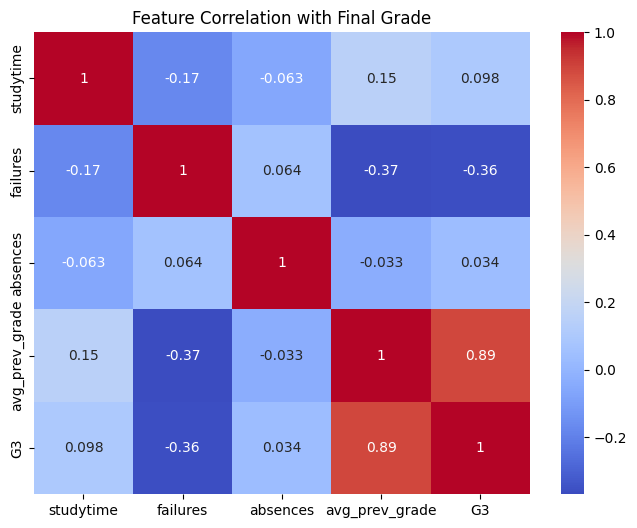

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['studytime', 'failures', 'absences', 'avg_prev_grade', 'G3']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Feature Correlation with Final Grade")
plt.show()

## Feature Selection
The following features are selected based on correlation and domain relevance:
- Study Time
- Number of Failures
- Absences
- Average Previous Grade

In [13]:
features = ['studytime', 'failures', 'absences', 'avg_prev_grade']
X = df[features]
y = df['G3']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Regression Model Training & Evaluation
Two regression models are trained and evaluated using:
- RMSE
- MAE
- R² Score

In [14]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

regression_results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    regression_results[name] = {
        "RMSE": np.sqrt(mean_squared_error(y_test, preds)),
        "MAE": mean_absolute_error(y_test, preds),
        "R2": r2_score(y_test, preds)
    }

regression_results

{'Linear Regression': {'RMSE': np.float64(2.2008399212167733),
  'MAE': 1.5514486810359336,
  'R2': 0.7637802880676656},
 'Random Forest': {'RMSE': np.float64(1.926541558065684),
  'MAE': 1.2494298774362063,
  'R2': 0.8189927423023093}}

## Cross-Validation
Cross-validation is used to evaluate model stability and generalization performance.

In [15]:
rf_cv = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(
    rf_cv, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

print("Cross-Validation RMSE:", -cv_scores.mean())

Cross-Validation RMSE: 1.9646438756006526


## Feature Importance
Random Forest feature importance highlights the most influential predictors.

In [16]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": rf_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importance

,Feature,Importance
3,avg_prev_grade,0.831187
2,absences,0.114356
0,studytime,0.034587
1,failures,0.019870


## Residual Analysis
Residual analysis evaluates whether prediction errors are unbiased.

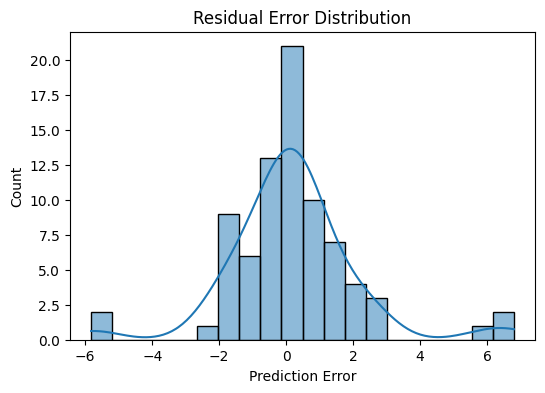

In [17]:
rf_preds = rf_model.predict(X_test)
errors = y_test - rf_preds

plt.figure(figsize=(6,4))
sns.histplot(errors, bins=20, kde=True)
plt.title("Residual Error Distribution")
plt.xlabel("Prediction Error")
plt.show()

## Actual vs Predicted Grades
This visualization compares predicted grades with actual grades.

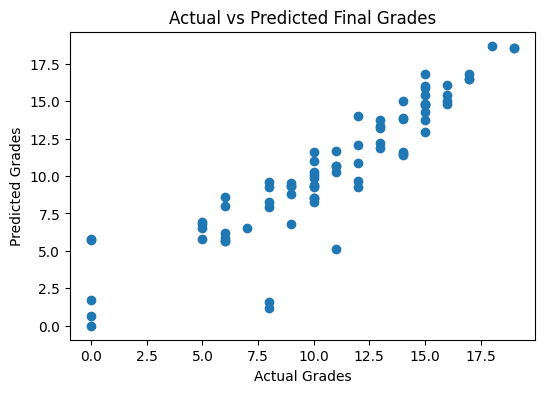

In [18]:
plt.figure(figsize=(6,4))
plt.scatter(y_test, rf_preds)
plt.xlabel("Actual Grades")
plt.ylabel("Predicted Grades")
plt.title("Actual vs Predicted Final Grades")
plt.show()

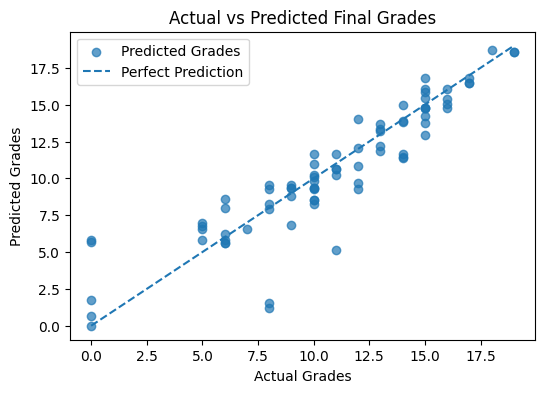

In [19]:
plt.figure(figsize=(6,4))

# Scatter plot: Predicted vs Actual
plt.scatter(y_test, rf_preds, alpha=0.7, label="Predicted Grades")

# Perfect prediction line (y = x)
min_val = min(y_test.min(), rf_preds.min())
max_val = max(y_test.max(), rf_preds.max())
plt.plot([min_val, max_val], [min_val, max_val],
         linestyle='--', label="Perfect Prediction")

plt.xlabel("Actual Grades")
plt.ylabel("Predicted Grades")
plt.title("Actual vs Predicted Final Grades")
plt.legend()
plt.show()

Student Risk Classification

Students with a final grade below 10 are classified as **academically at risk**.
This classification task helps identify students requiring early intervention.

In [20]:
df['at_risk'] = (df['G3'] < 10).astype(int)

X_cls = df[features]
y_cls = df['at_risk']

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42
)

To address class imbalance and prioritize the detection of at-risk students, a balanced logistic regression model was trained using class weights. This significantly improved recall to over 96%, ensuring that most at-risk students are correctly identified, while maintaining strong overall accuracy.


In [23]:
clf_bal = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'
)

clf_bal.fit(X_train_c, y_train_c)
y_pred_bal = clf_bal.predict(X_test_c)

print("Accuracy:", accuracy_score(y_test_c, y_pred_bal))
print("Precision:", precision_score(y_test_c, y_pred_bal))
print("Recall:", recall_score(y_test_c, y_pred_bal))
print("F1 Score:", f1_score(y_test_c, y_pred_bal))


Accuracy: 0.8987341772151899
Precision: 0.7878787878787878
Recall: 0.9629629629629629
F1 Score: 0.8666666666666667
